# Reading in data

In [32]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('/content/summarized data.xlsx - 工作表2.3.csv')
features.head(3)

,Date,House_Price_Index,Mortgage_Rate,Personal_Income,Resident_Population,Unemployment_Rate,Owners_Equivalent_Rent,CPI,GDP
0,2001-01-01,118.201625,7.03,43578,4443.310,3.2,225.0,189.0,236051.306
1,2001-02-01,119.800195,7.05,43121,4459.011,3.1,224.8,190.9,240457.644
2,2001-03-01,121.425731,6.95,43121,4459.011,3.3,226.1,190.9,240457.644


In [33]:
# representing date numerically
import numpy as np
dates = np.array(features['Date'])
years = []
months = []
days = []
for x in dates:
  years.append(int(x[:4]))
  months.append(int(x[5:7]))
  days.append(int(x[8:10]))
features['Year'] = years
features['Month'] = months
features['Day'] = days
features.head()

,Date,House_Price_Index,Mortgage_Rate,Personal_Income,Resident_Population,Unemployment_Rate,Owners_Equivalent_Rent,CPI,GDP,Year,Month,Day
0,2001-01-01,118.201625,7.03,43578,4443.310,3.2,225.0,189.0,236051.306,2001,1,1
1,2001-02-01,119.800195,7.05,43121,4459.011,3.1,224.8,190.9,240457.644,2001,2,1
2,2001-03-01,121.425731,6.95,43121,4459.011,3.3,226.1,190.9,240457.644,2001,3,1
3,2001-04-01,122.707721,7.08,43121,4459.011,3.0,227.4,190.9,240457.644,2001,4,1
4,2001-05-01,123.794561,7.15,43121,4459.011,3.1,228.7,190.9,240457.644,2001,5,1


# Creating train and test sets

In [34]:
# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(features['House_Price_Index'])
dates = np.array(features['Date'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('House_Price_Index', axis = 1)
features= features.drop('Date', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [35]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [36]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (153, 10)
Training Labels Shape: (153,)
Testing Features Shape: (52, 10)
Testing Labels Shape: (52,)


# Creating a random forest regressor, training, and testing it

In [37]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [38]:
#trying out a regressor with different hyperparameters
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1) 

In [39]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2)) #omg wait that's not a lot of error I think

Mean Absolute Error: 2.26


In [40]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #woah that is quite accurate....

Accuracy: 98.62 %.


# Visualizing one decision tree

In [41]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

In [42]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 14


# Variable importance

In [43]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Owners_Equivalent_Rent Importance: 0.3
Variable: Unemployment_Rate    Importance: 0.25
Variable: CPI                  Importance: 0.2
Variable: Personal_Income      Importance: 0.06
Variable: GDP                  Importance: 0.06
Variable: Resident_Population  Importance: 0.05
Variable: Year                 Importance: 0.05
Variable: Mortgage_Rate        Importance: 0.04
Variable: Month                Importance: 0.01
Variable: Day                  Importance: 0.0


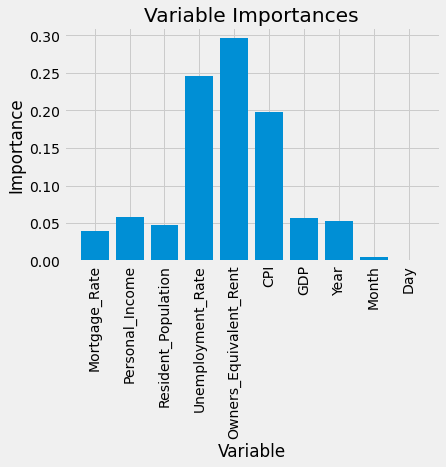

In [44]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [45]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Owners_Equivalent_Rent'), feature_list.index('CPI')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.') #still seem like quite good results omg

Mean Absolute Error: 2.33
Accuracy: 98.56 %.


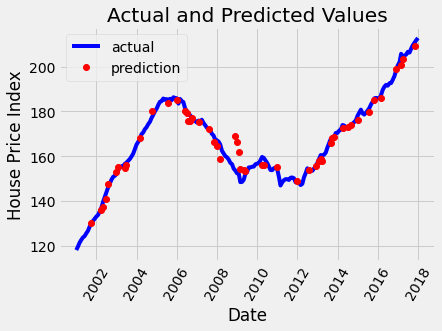

In [46]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
months = features[:, feature_list.index('Month')]
days = features[:, feature_list.index('Day')]
years = features[:, feature_list.index('Year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('Month')]
days = test_features[:, feature_list.index('Day')]
years = test_features[:, feature_list.index('Year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');